In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
import codebase

In [2]:
from codebase import volume_pipeline

In [3]:
res_shp = codebase.load_data.load_GRanD()

In [4]:
res_ref_M = codebase.load_data.load_formatted_usbr_data('powell',monthly=True)
# res_ref_M = res_ref.resample('M',label='left',closed='left').mean()
# res_ref_M.index = res_ref_M.index + pd.Timedelta('1D') # resampling makes the index one day too early, corrects to first of the month
res_ref_elev = res_ref_M['Lake/Reservoir Elevation [ft]']
res_ref_M.columns

Index(['Lake/Reservoir Area [acres]', 'Lake/Reservoir Bank Storage [af]',
       'Lake/Reservoir Change In Storage [af]',
       'Lake/Reservoir Elevation [ft]', 'Lake/Reservoir Evaporation [af]',
       'Lake/Reservoir Inflow - Unregulated [cfs]',
       'Lake/Reservoir Inflow Volume - Unregulated [af]',
       'Lake/Reservoir Inflow [af]', 'Lake/Reservoir Inflow [cfs]',
       'Lake/Reservoir Release - Bypass [af]',
       'Lake/Reservoir Release - Bypass [cfs]',
       'Lake/Reservoir Release - Powerplant [af]',
       'Lake/Reservoir Release - Powerplant [cfs]',
       'Lake/Reservoir Release - Spillway [cfs]',
       'Lake/Reservoir Release - Total [af]',
       'Lake/Reservoir Release - Total [cfs]', 'Lake/Reservoir Storage [af]'],
      dtype='object', name='Variable')

In [5]:
# Volume pipeline with crs projection
dem_DA , fw_DA = volume_pipeline.create_aligned_DEM_CYGNSS_subsets('glen canyon',res_shp,epsg_code=54017)
fw_diff_DA = volume_pipeline.difference_over_time(fw_DA)
change_cond_DA = volume_pipeline.decide_expansion_or_shrinkage_vectorize(fw_diff_DA, input_core_dims = ['y','x'])
test_vol = volume_pipeline.calculate_rough_volume(dem_DA,fw_DA,fw_diff_DA,change_cond_DA,area_kwargs = {'input_core_dims' : [['y','x']], "vectorize": True})

# Elevation comparison

## Elevation within a month compared to USBR

In [6]:
res_DEM = volume_pipeline.grab_DEM_of_conditional_area(dem_DA,fw_DA)

In [7]:
dem_1m = res_DEM.isel(time=8)
dem_1m_time = dem_1m['time'].values
res_elev_1m_ft = res_ref_M.loc[dem_1m_time,'Lake/Reservoir Elevation [ft]']
res_elev_1m = codebase.utils.convert_from_ft_to_m(res_elev_1m_ft)

1088 meters


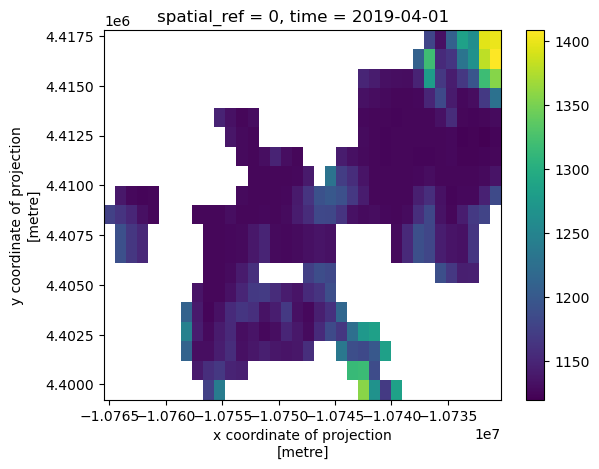

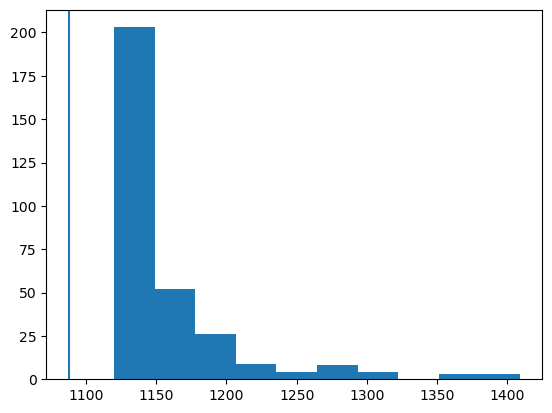

In [8]:
print(f'{res_elev_1m:.0f} meters')
_ = codebase.plotting_functions.map_data_array_values(dem_1m)#, hist_kwargs={'range':(100,200)})

plt.axvline(x=res_elev_1m)

## Elevation with existing methods

In [9]:
from scipy.stats import norm
norm_fits = volume_pipeline.loop_through_time_series_to_get_fit_params(dem_DA, fw_DA, 1, norm)
norm_elev_m = [val[0] for val in norm_fits]
norm_elev_series_m = pd.Series(index=fw_DA['time'], data = norm_elev_m)

In [10]:
ref_elev_m = codebase.utils.convert_from_ft_to_m(res_ref_elev)

In [14]:
norm_elev_match ,ref_elev_match = codebase.time_series_calcs.intersecting_timeframes(norm_elev_series_m,ref_elev_m, buffer=0)

In [15]:
norm_elev_match.shape ,ref_elev_match.shape

((57,), (57,))

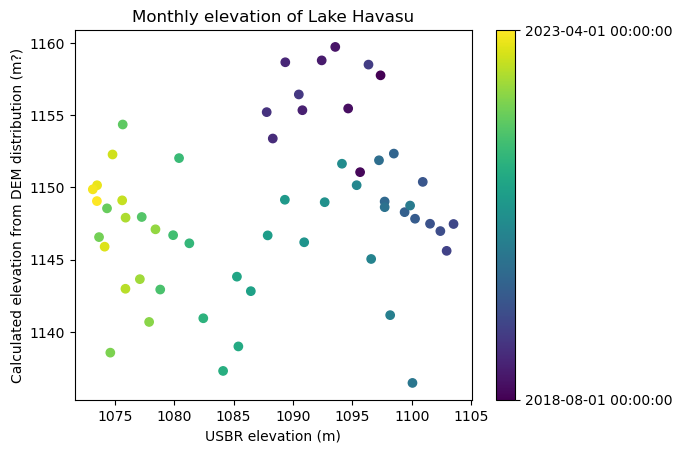

In [16]:
# Comparison of ref and calculated heights
mn = ref_elev_match.index[0].timestamp()*1e9
mx = ref_elev_match.index[-1].timestamp()*1e9

plt.scatter(ref_elev_match, norm_elev_match ,c=ref_elev_match.index,vmin=mn, vmax=mx)
cbar = plt.colorbar()
cbar.set_ticks([mn,mx])
cbar.set_ticklabels([ref_elev_match.index[0],ref_elev_match.index[-1]])
plt.xlabel('USBR elevation (m)')
plt.ylabel('Calculated elevation from DEM distribution (m?)')
plt.title('Monthly elevation of Lake Havasu');

## Change in elevation (aka height) comparison

In [17]:
# Grab height from volume pipeline
height_array = volume_pipeline.calculate_height_time_series_from_start_and_change_in_DEM(
        dem_DA, fw_DA, fw_diff_DA, change_cond_DA) * change_cond_DA.values
height_series = pd.Series(index = fw_diff_DA['time'], data = height_array)

height_series

2018-09-01   -46.769503
2018-10-01    41.314605
2018-11-01    31.517612
2018-12-01   -37.277694
2019-01-01   -45.747704
2019-02-01    -0.649687
2019-03-01   -12.612430
2019-04-01     9.427053
2019-05-01   -16.656548
2019-06-01    20.050659
2019-07-01   -33.261472
2019-08-01   -12.817994
2019-09-01    12.685025
2019-10-01    -8.743375
2019-11-01    17.760017
2019-12-01   -21.576658
2020-01-01    23.675015
2020-02-01    -3.266635
2020-03-01     5.971531
2020-04-01    19.443989
2020-05-01   -21.464957
2020-06-01   -15.621740
2020-07-01    34.814986
2020-08-01   -13.922534
2020-09-01    20.846079
2020-10-01    34.583363
2020-11-01    -6.563091
2020-12-01     2.301940
2021-01-01   -33.447308
2021-02-01    -2.838076
2021-03-01   -32.516531
2021-04-01    15.721122
2021-05-01    -8.717216
2021-06-01   -13.353377
2021-07-01    -7.670254
2021-08-01    12.878911
2021-09-01   -10.436881
2021-10-01    20.065531
2021-11-01    -1.542952
2021-12-01   -20.919754
2022-01-01    30.945875
2022-02-01    -7

In [18]:
res_ref_elev

Datetime (UTC)
2018-01-01    3621.084333
2018-02-01    3617.694643
2018-03-01    3614.220968
2018-04-01    3610.879333
2018-05-01    3609.949355
                 ...     
2023-09-01    3573.823667
2023-10-01    3573.096452
2023-11-01    3572.132667
2023-12-01    3570.199677
2024-01-01    3568.895000
Name: Lake/Reservoir Elevation [ft], Length: 73, dtype: float64

In [19]:
ref_height_m = res_ref_elev.diff()[1:]/3.28

In [23]:
height_series_match ,res_ref_elev_match = codebase.time_series_calcs.intersecting_timeframes(height_series,ref_height_m,buffer=0)

In [24]:
mn = res_ref_elev_match.index[0].timestamp()*1e9
mx = res_ref_elev_match.index[-1].timestamp()*1e9

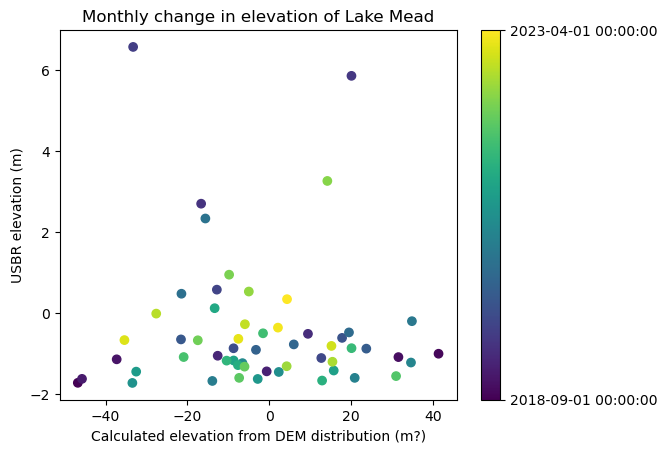

In [25]:
# Comparison of ref and calculated heights
plt.scatter(height_series_match ,res_ref_elev_match,c=res_ref_elev_match.index,vmin=mn, vmax=mx)
cbar = plt.colorbar()
cbar.set_ticks([mn,mx])
cbar.set_ticklabels([res_ref_elev_match.index[0],res_ref_elev_match.index[-1]])
plt.xlabel('Calculated elevation from DEM distribution (m?)')
plt.ylabel('USBR elevation (m)')
plt.title('Monthly change in elevation of Lake Mead');

Conclusion: DEM extraction is currently not a good match to reference elevation series.

<Axes: >

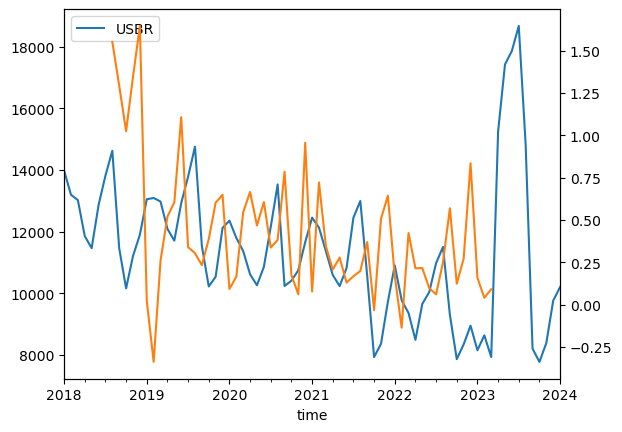

In [26]:
res_ref_M.plot(y='Lake/Reservoir Release - Total [cfs]', label='USBR')
test_vol.to_dataframe()['Watermask'].plot(label='Experimental',secondary_y= True)

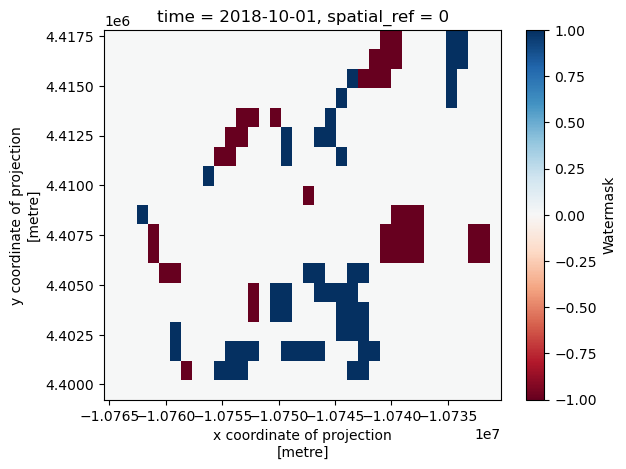

In [27]:
fw_diff_DA.isel(time=1).plot(cmap='RdBu')